# Background

Simple NN using pyTorch:
    * Classification problem (binary),
    * Based on features like: age, sex, education, marital status, workclass etc. needs to predict whether persons'income  
    is higher or lower than 50k.

In [363]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import skorch

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# DF import

In [364]:
df = pd.read_csv('income.csv')

In [365]:
df.head()

,age,sex,education,education-num,marital-status,workclass,occupation,hours-per-week,income,label
0,27,Male,HS-grad,9,Never-married,Private,Craft-repair,40,<=50K,0
1,47,Male,Masters,14,Married,Local-gov,Exec-managerial,50,>50K,1
2,59,Male,HS-grad,9,Divorced,Self-emp,Prof-specialty,20,<=50K,0
3,38,Female,Prof-school,15,Never-married,Federal-gov,Prof-specialty,57,>50K,1
4,64,Female,11th,7,Widowed,Private,Farming-fishing,40,<=50K,0


In [366]:
df['label'].value_counts()

0    21700
1     8300
Name: label, dtype: int64

In [367]:
cat_cols = ['sex', 'education-num', 'marital-status', 'workclass', 'occupation']
num_cols = ['age', 'hours-per-week']
y_col = ['label']

# Standarizing numerical variables

In [368]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [369]:
X_train, X_test, y_train, y_test = train_test_split(
    df[cat_cols+num_cols], df[y_col], test_size=.2)

In [370]:
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Encoding categorical variables

In [371]:
encoder = OneHotEncoder(sparse=False, drop='first')

In [372]:
train_encoded = pd.DataFrame(encoder.fit_transform(X_train[cat_cols]), columns=encoder.get_feature_names(cat_cols))
X_train = pd.concat([X_train.reset_index(drop=True), train_encoded], axis=1).drop(columns=cat_cols)

In [376]:
test_encoded = pd.DataFrame(encoder.transform(X_test[cat_cols]), columns=encoder.get_feature_names(cat_cols))
X_test = pd.concat([X_test.reset_index(drop=True), test_encoded], axis=1).drop(columns=cat_cols)

# Changing DF to tensors (using GPU)

In [ ]:
X_train_torch = torch.tensor(X_train.values,dtype=torch.float).cuda()
X_test_torch = torch.tensor(X_test.values,dtype=torch.float).cuda()

y_train_torch = torch.tensor(y_train.values).flatten().cuda()
y_test_torch = torch.tensor(y_test.values).flatten().cuda()

# Simple neural network

This neural network contains 2 hidden layers - both are fully connected and their activation function is ReLU. 1st hidden layer contains 240 neurons and 2nd - 200.  

Activation function of output layer is log_softmax, because of nature of the problem (classification).

In [410]:
class ClassificationNetwork(nn.Module):
    def __init__(self, in_size=36):
        super().__init__()
        self.fc1 = nn.Linear(in_size, 240)
        self.fc2 = nn.Linear(240, 200)
        self.fc3 = nn.Linear(200, 2)
                
    def forward(self, X):
        X  = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim =1)

# Training 1st model

First model is trained during 2000 epochs. Its loss function is Cross Entropy and optimizer is Adam (gives far better output than SGD).

In [411]:
torch.manual_seed(0)
model = ClassificationNetwork()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

In [412]:
import time
start_time = time.time()

epochs = 2000
train_loss = []
test_loss = []

for i in range(epochs):
    
    i += 1
    y_pred = model(X_train_torch)
    loss = criterion(y_pred, y_train_torch)
    train_loss.append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i%25==0:
        print(f'Epoch {i} Loss: {loss.item()}')
        
    with torch.no_grad():
        y_val = model(X_test_torch)
        loss = criterion(y_val, y_test_torch)
        test_loss.append(loss)
            
total_time = time.time() - start_time
print(f'Duration: {total_time/60}')

Epoch 25 Loss: 0.30487075448036194
Epoch 50 Loss: 0.25826728343963623
Epoch 75 Loss: 0.2461037039756775
Epoch 100 Loss: 0.2397603690624237
Epoch 125 Loss: 0.2351505160331726
Epoch 150 Loss: 0.23131868243217468
Epoch 175 Loss: 0.22781911492347717
Epoch 200 Loss: 0.22431626915931702
Epoch 225 Loss: 0.22066955268383026
Epoch 250 Loss: 0.2167430818080902
Epoch 275 Loss: 0.2124786525964737
Epoch 300 Loss: 0.20809829235076904
Epoch 325 Loss: 0.2037687450647354
Epoch 350 Loss: 0.1995064914226532
Epoch 375 Loss: 0.19582727551460266
Epoch 400 Loss: 0.192594975233078
Epoch 425 Loss: 0.18912465870380402
Epoch 450 Loss: 0.1863681674003601
Epoch 475 Loss: 0.1839451938867569
Epoch 500 Loss: 0.18105611205101013
Epoch 525 Loss: 0.17846405506134033
Epoch 550 Loss: 0.17642730474472046
Epoch 575 Loss: 0.17459990084171295
Epoch 600 Loss: 0.17303717136383057
Epoch 625 Loss: 0.17134034633636475
Epoch 650 Loss: 0.1696850210428238
Epoch 675 Loss: 0.16810090839862823
Epoch 700 Loss: 0.16655343770980835
Epoch 7

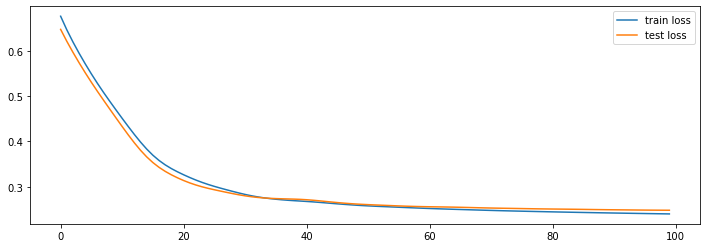

In [434]:
plt.figure(figsize = (12,4))
plt.plot(train_loss, label = 'train loss')
plt.plot(test_loss, label = 'test loss')
plt.legend()

Analyzing loss values, we can see that when train loss constantly decreases, test loss increases after around 100 epochs. That is why I trained 2nd model.

In [414]:
torch.manual_seed(0)
model = ClassificationNetwork()
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
import time
start_time = time.time()

epochs = 100
train_loss = []
test_loss = []

for i in range(epochs):
    
    i += 1
    y_pred = model(X_train_torch)
    loss = criterion(y_pred, y_train_torch)
    train_loss.append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i%25==0:
        print(f'Epoch {i} Loss: {loss.item()}')
        
    with torch.no_grad():
        y_val = model(X_test_torch)
        loss = criterion(y_val, y_test_torch)
        test_loss.append(loss)
            
total_time = time.time() - start_time
print(f'Duration: {total_time/60}')

Epoch 25 Loss: 0.30487075448036194
Epoch 50 Loss: 0.25826728343963623
Epoch 75 Loss: 0.2461037039756775
Epoch 100 Loss: 0.2397603690624237
Duration: 0.03943494160970052


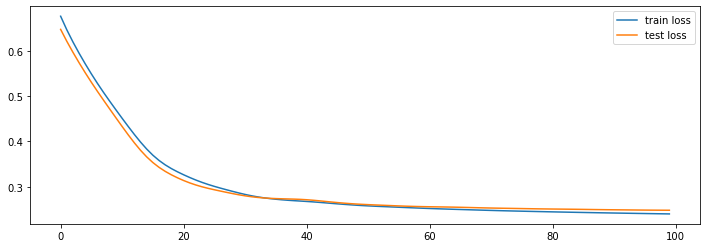

In [435]:
plt.figure(figsize = (12,4))
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.legend()

# Evaluation on test data

In [427]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [418]:
with torch.no_grad():
    y_pred = model(X_test_torch)

In [426]:
confusion_matrix(y_test, np.argmax(y_pred.cpu(), axis=1))

array([[3822,  481],
       [ 213, 1484]], dtype=int64)

In [431]:
print(f'Test accuracy: {100*accuracy_score(y_test, np.argmax(y_pred.cpu(), axis=1)):.2f}%')

Test accuracy: 88.43%


Our test accuracy is almost 90% which is very good score. Of course there is a lot of things to improve like:
* using embeddings instead of one hot encoding,
* adding more layers or changing no of neurons.
